# Predict basal area from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [3]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular import *

Run the example workflow for predicting the basal area of the field plot from LiDAR-derived features.

# Read and preprocess data

In [4]:
preprocessor = EnvecoPreprocessor('../../enveco_data/enveco/AV.leaf.on.train.csv', 
                                  '../../enveco_data/enveco/AV.leaf.on.val.csv',
                                  '../../enveco_data/enveco/AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [68]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col='g', path='../../enveco_data/enveco/AV_las/', min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=True, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True,
                                                     log_y=True)

Adding height based features
Adding point distribution based features
Adding intensity based features
Adding height quantiles
Adding point proportions
Adding canopy densities


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [69]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

Check the distribution of the target variable `g`, in order to get limits for `sigmoid_range`.

In [70]:
trainval_tb.train.y.describe()

count    1044.000000
mean        2.903793
std         0.473430
min         0.530628
25%         2.653242
50%         2.954910
75%         3.234749
max         4.226834
Name: g, dtype: float64

In [71]:
trainval_tb.valid.y.describe()

count    225.000000
mean       2.900115
std        0.489632
min        0.470004
25%        2.646175
50%        2.960105
75%        3.206803
max        3.903991
Name: g, dtype: float64

In [72]:
test_tb.train.y.describe()

count    225.000000
mean       2.919878
std        0.489392
min        0.875469
25%        2.681021
50%        2.970414
75%        3.238678
max        3.962716
Name: g, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 70 m² as the maximum value for basal area.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [73]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,5))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 58'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
Linear               64 x 200             11,600     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0003311311302240938)

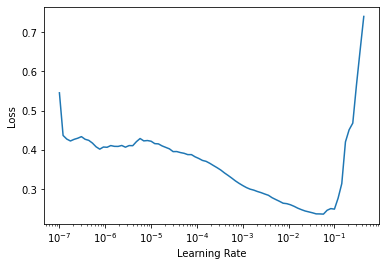

In [74]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.288659,0.171919,0.414631,14.297041,-0.223594,-7.709828,0.343677,0.279693,00:00
1,0.180850,0.068494,0.261714,9.024248,0.023198,0.799911,0.202583,0.713023,00:00
2,0.128990,0.052131,0.228323,7.872897,-0.004478,-0.154396,0.171418,0.781579,00:00
3,0.098185,0.044341,0.210574,7.260881,0.007074,0.243918,0.157609,0.814218,00:00
4,0.080411,0.045527,0.213370,7.357287,-0.009046,-0.311933,0.160813,0.809252,00:00
5,0.066781,0.043576,0.208749,7.197963,0.020977,0.723315,0.154787,0.817424,00:00
6,0.057614,0.050265,0.224198,7.730664,-0.010620,-0.366182,0.172247,0.789400,00:00
7,0.050643,0.043885,0.209488,7.223448,0.017060,0.588246,0.154677,0.816129,00:00
8,0.045411,0.042832,0.206960,7.136257,0.010553,0.363889,0.153335,0.820541,00:00
9,0.040729,0.042659,0.206541,7.121832,0.014491,0.499657,0.152380,0.821265,00:00


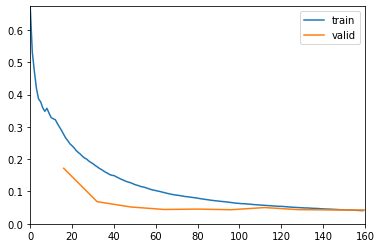

In [75]:
learn.fit_one_cycle(10, max_lr=1e-2, cbs=ShowGraphCallback())

See validation results

In [76]:
learn.validate()

(#7) [0.04265929386019707,0.2065412700176239,7.121831893920898,0.014490621164441109,0.49965688586235046,0.1523803472518921,0.8212653686326831]

`RegressionInterpretation` can be used to plot results.

In [77]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

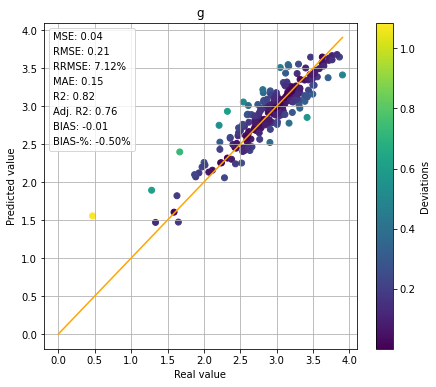

In [78]:
reg_interp.plot_results()
plt.show()

If target variable is log-transformed, specify `log_y = True` to inverse transformations.

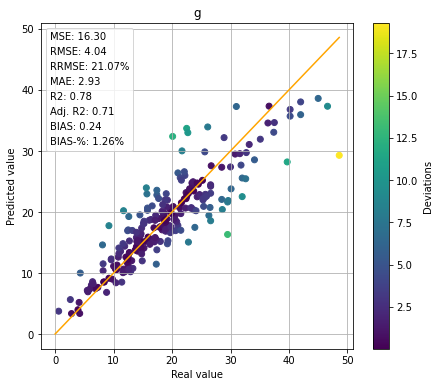

In [79]:
reg_interp.plot_results(log_y=True)
plt.show()

Evaluate test set.

In [84]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [85]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls)

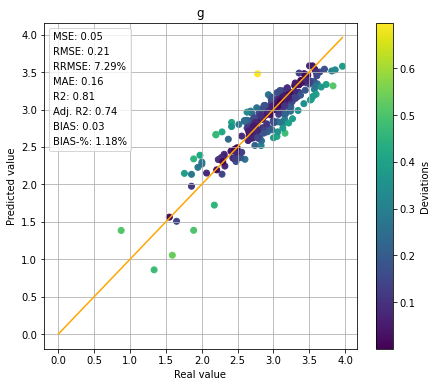

In [86]:
test_interp.plot_results()
plt.show()

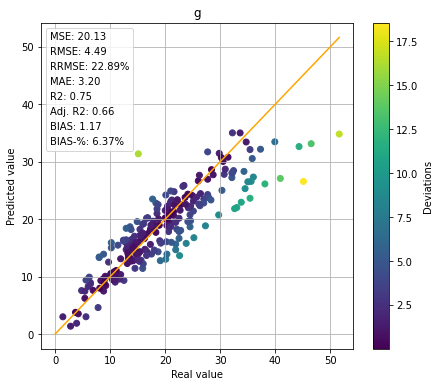

In [87]:
test_interp.plot_results(log_y=True)
plt.show()

# Ensemble of ANNs

Fit several models at once.

In [88]:
ensemble = ANNEnsemble(dls, 
                       y_range=(0,5), 
                       metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], n_models=10)

In [ ]:
ensemble.fit_one_cycle(10, 1e-2)

In [90]:
res = ensemble.validate()

See ensemble validation results.

In [92]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,0.193963,6.688108,0.015083,0.520073,0.141603,0.842373
1,0,0.220398,7.599619,0.024184,0.833907,0.160274,0.796479
2,1,0.206861,7.132844,0.014321,0.493806,0.153710,0.820712
3,2,0.213028,7.345510,0.022867,0.788503,0.155615,0.809862
4,3,0.193068,6.657239,0.003829,0.132019,0.145480,0.843824
5,4,0.203790,7.026963,0.007953,0.274214,0.149076,0.825995
6,5,0.209770,7.233173,0.013144,0.453209,0.157392,0.815633
7,6,0.212291,7.320084,0.015779,0.544072,0.157003,0.811176
8,7,0.213286,7.354415,0.010861,0.374497,0.157974,0.809401
9,8,0.197768,6.819312,0.014158,0.488187,0.149116,0.836127


In [93]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

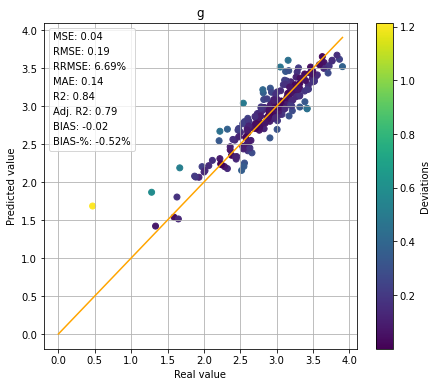

In [94]:
ens_int.plot_results()
plt.show()

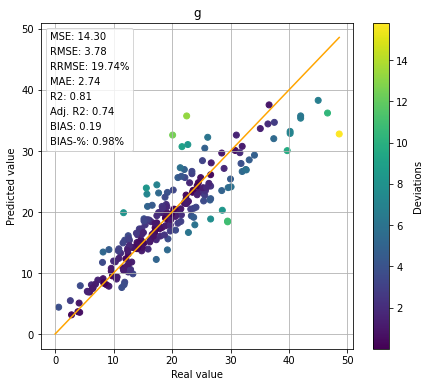

In [95]:
ens_int.plot_results(log_y=True)
plt.show()

Run test set predictions.

In [96]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,0.185872,6.365758,-0.026635,-0.912212,0.142094,0.855106
1,0,0.200689,6.873181,-0.012818,-0.439001,0.156022,0.831086
2,1,0.200828,6.877949,-0.034571,-1.183975,0.154600,0.830851
3,2,0.218418,7.480381,-0.022096,-0.756759,0.168929,0.799923
4,3,0.200709,6.873888,-0.023975,-0.821097,0.157455,0.831051
5,4,0.201475,6.900129,-0.036129,-1.237353,0.156203,0.829759
6,5,0.201178,6.889957,-0.034460,-1.180179,0.153052,0.830260
7,6,0.210454,7.207640,-0.026422,-0.904893,0.160533,0.814247
8,7,0.199605,6.836069,-0.028866,-0.988611,0.153732,0.832905
9,8,0.191934,6.573358,-0.018290,-0.626400,0.148182,0.845501


In [97]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

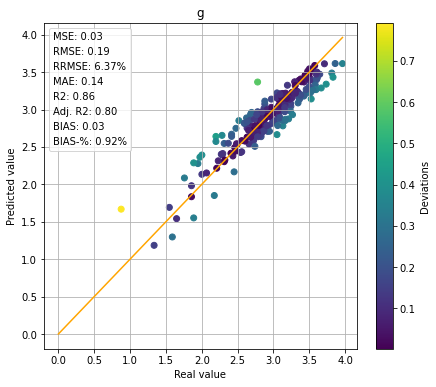

In [98]:
test_ens_interp.plot_results()
plt.show()

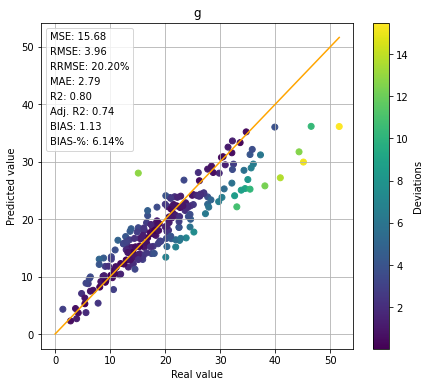

In [99]:
test_ens_interp.plot_results(log_y=True)
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [100]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [101]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [102]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [64]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

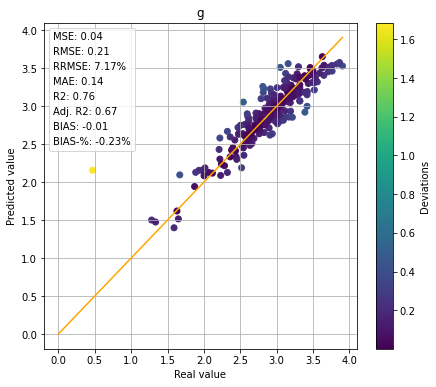

In [103]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

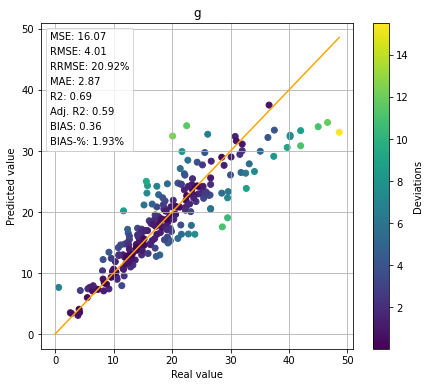

In [104]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=True)
plt.show()

Test results

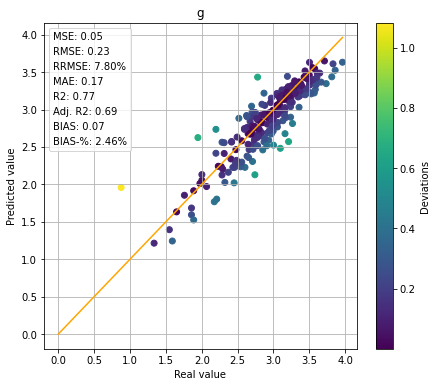

In [105]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()

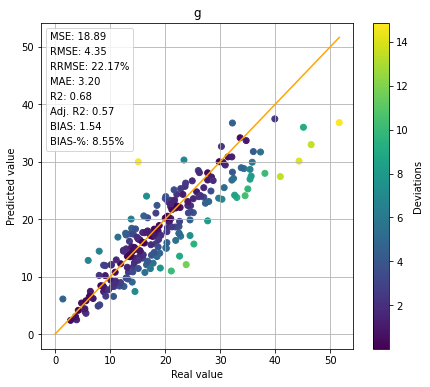

In [106]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys, log_y=True)
plt.show()